In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
annotations_df = pd.read_csv('annotations.csv' )
annotations_df.head()

NAME  r ankle_X  r ankle_Y  r knee_X  r knee_Y  r hip_X  r hip_Y  \
0  image1.jpg        663        800       740       637      816      487   
1  image2.jpg        695        825       826       633      932      542   
2  image3.jpg        719        846       824       702      955      582   
3  image4.jpg        698        825       822       648      944      511   
4  image5.jpg        681        825       786       669      908      508   

   l hip_X  l hip_Y  l knee_X  ...  r elbow_X  r elbow_Y  r shoulder_X  \
0      954      482      1032  ...        697        518           760   
1     1007      558      1196  ...        812        489           850   
2     1099      584      1243  ...        896        553           945   
3     1044      503      1181  ...        891        545           920   
4     1040      513      1132  ...        834        479           908   

   r shoulder_Y  l shoulder_X  l shoulder_Y  l elbow_X  l elbow_Y  l wrist_X  \
0           390           943           365       1076        454       1004   
1           382          1047           361       1066        521        972   
2           420          1143           420       1173        525       1240   
3           376          1094           363       1144        490       1147   
4           363          1114           395       1154        511       1172   

   l wrist_Y  
0        543  
1        638  
2        630  
3        593  
4        611  

[5 rows x 33 columns]

In [4]:
annotations_df.shape

(5, 33)

In [5]:
# store the images name in df_image
df_image = annotations_df['NAME']

In [6]:
# store the annotations data in df_pose_data without the image names
df_pose_data = annotations_df.iloc[:, 1:]

In [7]:
# convert pose data into an array
pose_array = df_pose_data.values

In [8]:
shape_ = pose_array.shape
shape_

(5, 32)

In [9]:
# create a data dictionary with image name as keys and pose data for each image as values 
img_dict = {}

In [10]:
for n in range(0,shape_[0]):
    image_str = df_image[n].split('.')
    img = image_str[0]
    img_dict[img] = pose_array[n,:]

In [11]:
img_dict

{'image1': array([ 663.    ,  800.    ,  740.    ,  637.    ,  816.    ,  487.    ,
         954.    ,  482.    , 1032.    ,  619.    , 1017.    ,  795.    ,
         885.    ,  485.    ,  852.    ,  378.    ,  852.7966,  400.3052,
         847.2034,  243.6948,  697.    ,  584.    ,  697.    ,  518.    ,
         760.    ,  390.    ,  943.    ,  365.    , 1076.    ,  454.    ,
        1004.    ,  543.    ]),
 'image2': array([ 695.    ,  825.    ,  826.    ,  633.    ,  932.    ,  542.    ,
        1007.    ,  558.    , 1196.    ,  697.    , 1223.    ,  801.    ,
         970.    ,  550.    ,  949.    ,  372.    ,  948.4837,  351.245 ,
         944.5163,  191.755 ,  748.    ,  579.    ,  812.    ,  489.    ,
         850.    ,  382.    , 1047.    ,  361.    , 1066.    ,  521.    ,
         972.    ,  638.    ]),
 'image3': array([ 719.    ,  846.    ,  824.    ,  702.    ,  955.    ,  582.    ,
        1099.    ,  584.    , 1243.    ,  723.    , 1302.    ,  849.    ,
        1027.    ,

In [12]:
import itertools

table = []
i = 0

for v in img_dict.values():
    #print(v)
    table.append([])
    for k in img_dict.keys():
        
        v1 = img_dict[k]
        cos_sim=cosine_similarity(v.reshape(1,-1),v1.reshape(1,-1))
        
        table[i].append(round(float(cos_sim.flatten()),3))
    i += 1

In [13]:
#table

In [14]:
table_dict = {}
img_list = []

for n in range(0,shape_[0]):
    image_str = df_image[n].split('.')
    img = image_str[0]
    img_list.append(img)
    table_dict[img] = table[n]

pd.DataFrame(table_dict, index = img_list)

image1  image2  image3  image4  image5
image1   1.000   0.998   0.998   0.997   0.998
image2   0.998   1.000   0.998   0.998   0.998
image3   0.998   0.998   1.000   0.999   0.999
image4   0.997   0.998   0.999   1.000   0.999
image5   0.998   0.998   0.999   0.999   1.000

In [15]:
model = VGG16(include_top=False, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [16]:
def compute_percentage_similarity(image_a, image_b):
    
    img1 = load_img(image_a, target_size=(224, 224))
    img_a = img_to_array(img1)
    
    # data needs to be reshaped for the model
    # preprocess image for the VGG model
    img_a = img_a.reshape((1, img_a.shape[0], img_a.shape[1], img_a.shape[2]))
    img_a = preprocess_input(img_a)

    img2 = load_img(image_b, target_size=(224, 224))
    img_b = img_to_array(img2)
    
    # data needs to be reshaped for the model
    # preprocess image for the VGG model
    img_b = img_b.reshape((1, img_b.shape[0], img_b.shape[1], img_b.shape[2]))
    img_b = preprocess_input(img_b)
    
    #print(img_a.shape, img_b.shape)
    feature_1 = model.predict(img_a)
    feature_2 = model.predict(img_b)

    cosine_loss = tf.keras.losses.CosineSimilarity()
    
    loss = cosine_loss(feature_1,feature_2).numpy()
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()
    
    #print(loss)
    percentage = -1*loss*100
    print(-1*loss*100,'%')
    
    return percentage

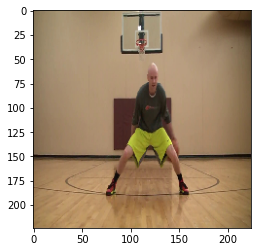

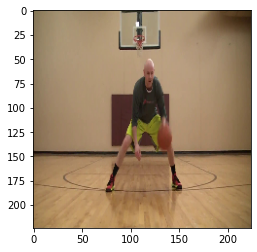

85.72768568992615 %


85.72768568992615

In [17]:
# Test compute_percentage_similarity function with image4 and image5
compute_percentage_similarity('image3.jpg','image4.jpg')


In [18]:
image_list = df_image.tolist()
image_list

['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg']

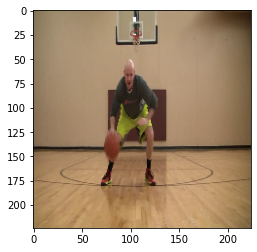

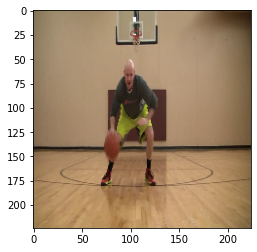

100.0 %


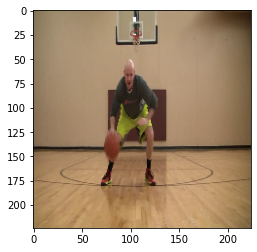

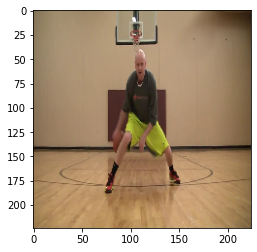

82.05004930496216 %


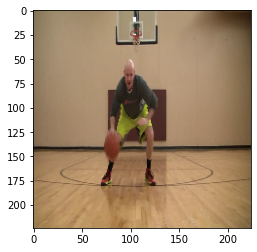

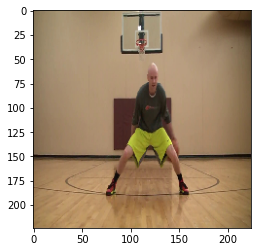

70.86303234100342 %


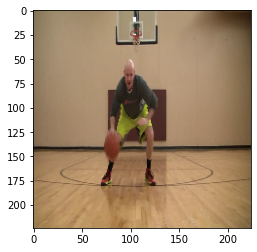

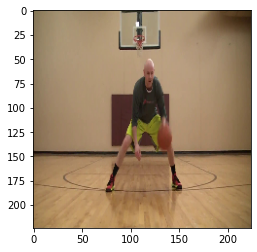

78.46477031707764 %


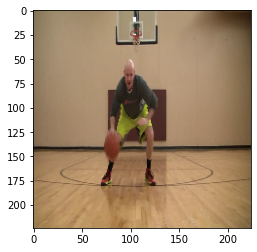

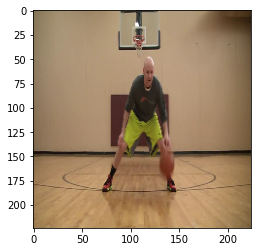

79.63873147964478 %


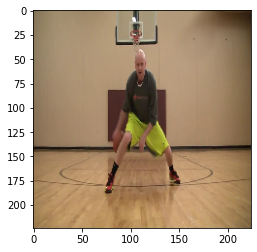

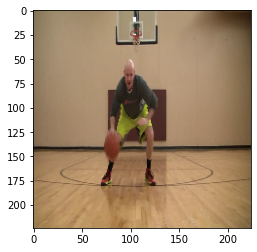

82.05004930496216 %


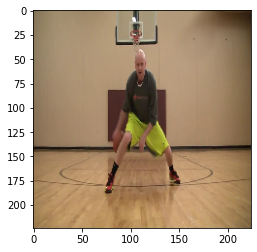

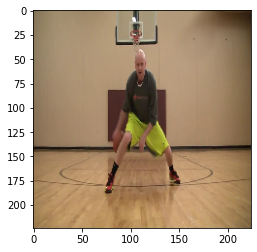

100.0 %


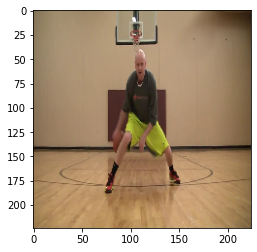

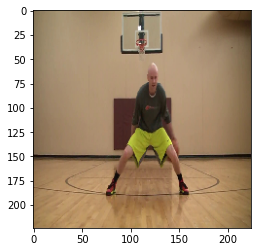

77.94921398162842 %


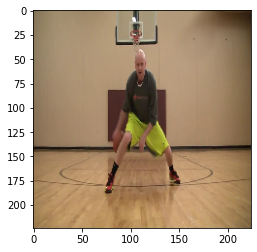

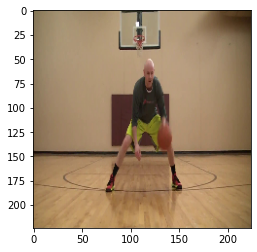

84.17497873306274 %


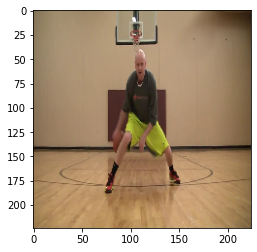

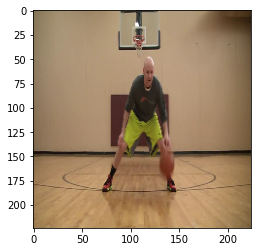

85.60200929641724 %


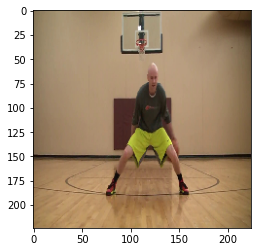

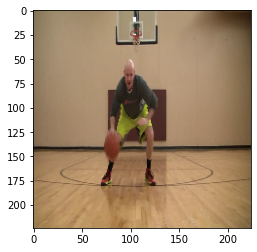

70.86303234100342 %


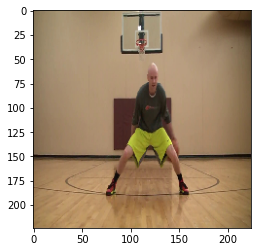

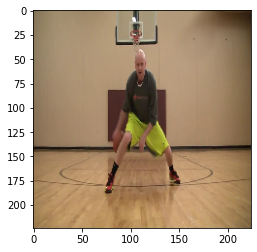

77.94921398162842 %


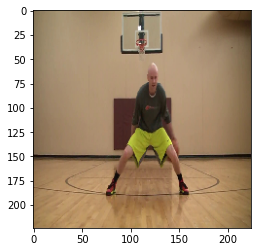

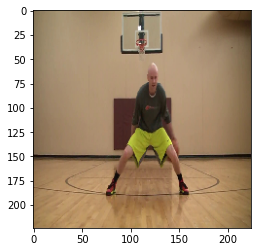

100.0 %


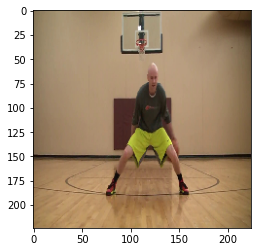

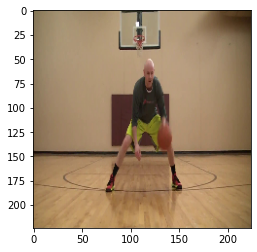

85.72768568992615 %


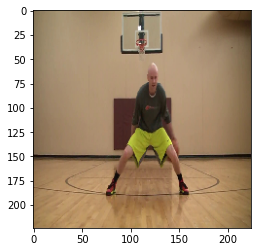

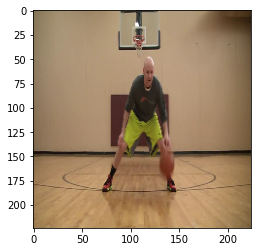

84.01985168457031 %


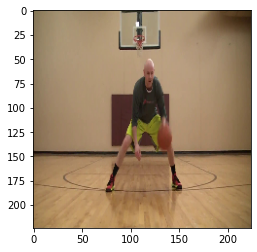

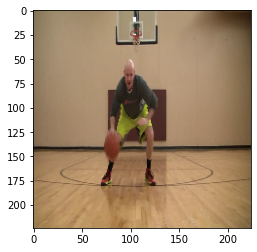

78.46477031707764 %


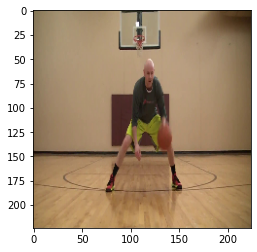

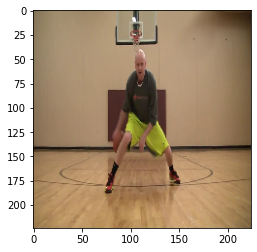

84.17497873306274 %


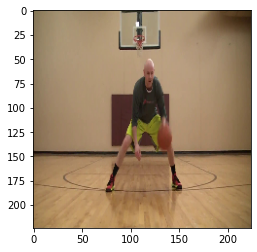

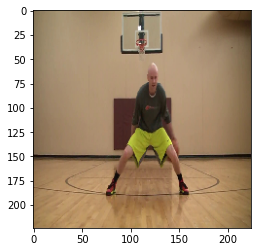

85.72768568992615 %


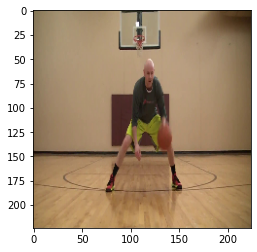

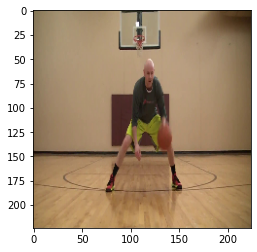

100.0 %


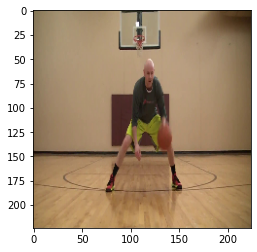

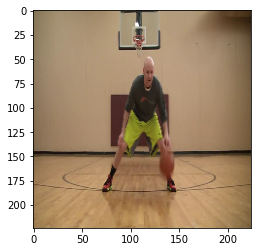

89.98942375183105 %


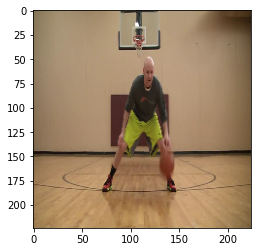

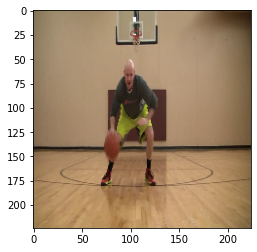

79.63873147964478 %


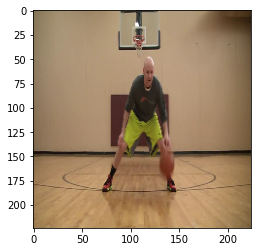

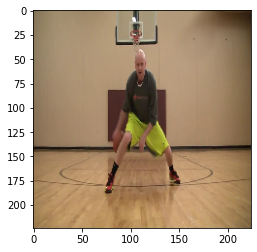

85.60200929641724 %


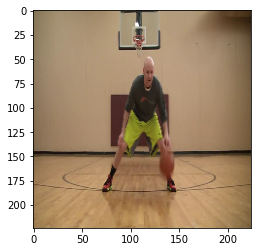

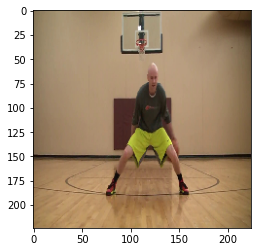

84.01985168457031 %


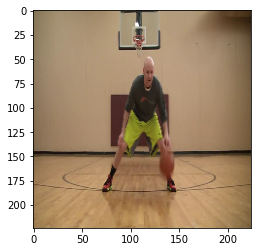

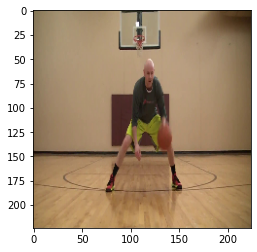

89.98942375183105 %


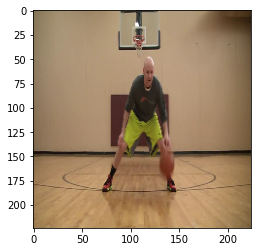

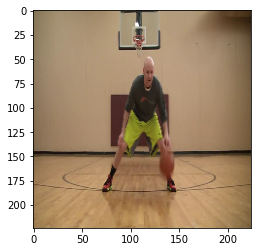

100.0 %


In [19]:
table = []
i = 0
for img_i in image_list:
    table.append([])
    for img_j in image_list:
        sim_percentage = compute_percentage_similarity(img_i, img_j)
        table[i].append(round(sim_percentage,2))
    i+=1

In [20]:
#table

In [21]:
table_dict = {}
img_list = []

for n in range(0,shape_[0]):
    image_str = df_image[n].split('.')
    img = image_str[0]
    img_list.append(img)
    table_dict[img] = table[n]

pd.DataFrame(table_dict, index = img_list)

image1  image2  image3  image4  image5
image1  100.00   82.05   70.86   78.46   79.64
image2   82.05  100.00   77.95   84.17   85.60
image3   70.86   77.95  100.00   85.73   84.02
image4   78.46   84.17   85.73  100.00   89.99
image5   79.64   85.60   84.02   89.99  100.00